# Наша первая свёрточная нейросеть 

Пришло время построить нашу первую свёрточную нейросеть. Будем использовать для этого датасет [MNIST.](https://www.cs.toronto.edu/~kriz/cifar.html) Набор данных включает в себя изображения рукописных цифр.  

<img src="https://cdn-images-1.medium.com/max/1600/1*Riqqoa7vKHXnFHvaGfDFjA.png" style="width:90%">


In [2]:
# подгружаем пакеты
import numpy as np
import random
from tqdm import tqdm

import keras
from keras import backend as K

%matplotlib inline
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/Cellar/python/3.6.4_4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## 1. Смотрим на данные 

Скачаеми приготовим данные. Буквально через минуту в наших руках окажутся $60 000$ картинок размера $28 \times 28$.

In [3]:
from keras.datasets import mnist
(x_tr, y_tr), (x_ts, y_ts) = mnist.load_data()

In [4]:
print("Train samples:", x_tr.shape, y_tr.shape)
print("Test samples:", x_ts.shape, y_ts.shape)

Train samples: (60000, 28, 28) (60000,)
Test samples: (10000, 28, 28) (10000,)


Нарисуем несколько рандомных картинок из тренировочной выборки. 

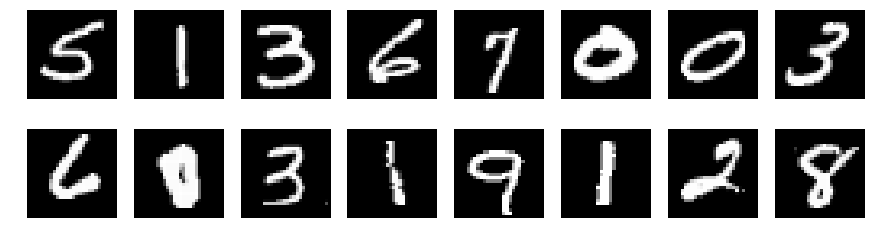

In [5]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_tr))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_tr[random_index, :], cmap = 'gray')
plt.show()

Отлично! Как вы помните, если пронормаровать данные, то сетка будет сходиться на порядок быстрее. 

Также, как вы помните из предыдущих скриптов, картинка - это тензор из циферок. Каждая циферка сообщает нам о яркости конкретного пикселя. Яркость измеряется по шкале от 0 до 255. В связи с этим фактом, нормализация будет немного странной: 

$$
x_{norm} = \frac{x}{255}
$$

In [6]:
# делай раз
x_train = x_tr/255
x_test =  x_ts/255

# Оставляем одну размерность на число каналов
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))     

Также мы помним, что классы нужно конвертировать одним горячи кодированием (one-hot encoding) в набор из дамми-переменных. 

```
0 → [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 → [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 → [0, 0, 1, 0, 0, 0, 0, 0, 0]
3 → [0, 0, 0, 1, 0, 0, 0, 0, 0]
etc...
```

In [7]:
# делай два! 
y_train = keras.utils.to_categorical(y_tr,10)
y_test = keras.utils.to_categorical(y_ts,10)

# Размерность после конвертации будет вот такой: (?, NUM_CLASSES)
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


## 2.  Выбираем для нашей нейросети архитектуру

Свёрточная нейронная сеть строится из нескольких разных типов слоёв: 

* [Conv2D](https://keras.io/layers/convolutional/#conv2d) - Конволюция:
    - **filters**: число выходных каналов; 
    - **kernel_size**: размер окна для свёртки;
    - **padding**: padding="same" добавляет нулевую каёмку по краям картинки, чтбы после свёртки размеры картинки не изменялись; padding='valid' ничего не добавляет;
    - **activation**: "relu", "tanh", etc.
    - **input_shape**: размер входа
* [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - макспулинг
* [Flatten](https://keras.io/layers/core/#flatten) - разворачивает картинку в вектор 
* [Dense](https://keras.io/layers/core/#dense) - полносвязный слой (fully-connected layer)
* [Activation](https://keras.io/layers/core/#activation) - функция активации
* [LeakyReLU](https://keras.io/layers/advanced-activations/#leakyrelu) - leaky relu активация
* [Dropout](https://keras.io/layers/core/#dropout) - дропаут.


В модели, которую мы определим ниже, на вход будет идти тензоры размера __(None, 28, 28, 1)__ и __(None, 10)__. На выходе мы будем получать вероятноть того, что объект относится к конкретному классу. Разменость __None__ заготовлена для размерности батча. 

In [137]:
# подгружаем важные строительные блоки
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, InputLayer
from keras.layers.advanced_activations import LeakyReLU

### 2.1 Полносвязная сетка 

Соберём двухслойную полносвязную сетку: 

* Вход
* Развернём картинку в вектор 
* Полносвязный слой с 64 нейронами
* RELU 
* Полносвязный слой с 32 нейронами 
* Dropout с вероятностью 0.5 
* RELU 
* Полносвязный слой с 16 нейронами 
* Dropout с вероятностью 0.5 
* RELU 
* Слой с 10 нейронами для клссов, в качестве активации используйте Softmax

In [93]:
model_1 = Sequential( )


# ваш код 


model_1.compile("adam", "categorical_crossentropy", metrics=["accuracy"])

In [94]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                50240     
_________________________________________________________________
activation_34 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
activation_35 (Activation)   (None, 32)                0         
__________

Можно визуализировать внутренними средствами keras сетку, которую мы собираем. 

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_1, show_shapes=True).create(prog='dot', format='svg'))

In [95]:
# обучаем 5 эпох
hist = model_1.fit(x_train, y_train, validation_split=0.2, epochs=5, verbose=1)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 5s 114us/step - loss: 1.2566 - acc: 0.5463 - val_loss: 0.3504 - val_acc: 0.9224
Epoch 2/5
48000/48000 [==============================] - 4s 85us/step - loss: 0.8018 - acc: 0.7271 - val_loss: 0.2362 - val_acc: 0.9395
Epoch 3/5
48000/48000 [==============================] - 4s 84us/step - loss: 0.6948 - acc: 0.7653 - val_loss: 0.2089 - val_acc: 0.9486
Epoch 4/5
48000/48000 [==============================] - 4s 86us/step - loss: 0.6348 - acc: 0.7863 - val_loss: 0.2017 - val_acc: 0.9507
Epoch 5/5
48000/48000 [==============================] - 4s 86us/step - loss: 0.5913 - acc: 0.8004 - val_loss: 0.1759 - val_acc: 0.9571


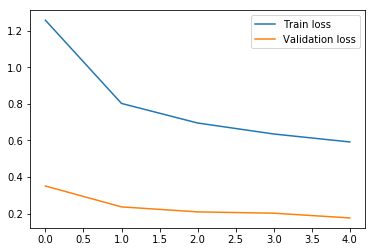

In [96]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])

In [97]:
print("\nLoss, Accuracy = ", model_1.evaluate(x_test, y_test))

10000/10000 [==============================] - 0s 38us/step

Loss, Accuracy =  [0.1857228140361607, 0.9544]


* Посмотрите на качество получившейся модели. Вернитесь по коду вверх и раскоментируйте строки, где картинки нормируются к отрезку $[0;1]$. Переобучите сетку. Что произошло с качеством? 
* Теперь попробуйте использовать в качестве функции активации линейную функцию. Что произошло с качеством модели?  

Можно посмотреть, где именно сетка ошибается. 

In [146]:
y_pred = model_1.predict_classes(x_test)
errors =  y_pred != y_ts

x_err = x_ts[errors]
y_err = y_ts[errors]
y_pred = y_pred[errors]

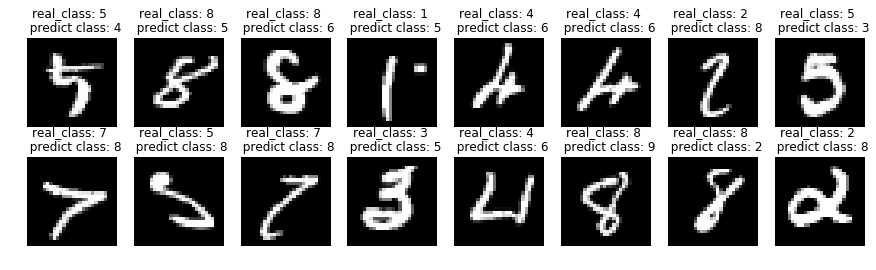

In [148]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_err[random_index, : ], cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(y_err[random_index], y_pred[random_index]))
plt.show()

### 2.2 Свёрточная сетка 

Теперь давайте соберём свёртоную сеть: 

* Свёртка с ядром $5 \times 5$, same padding и $32$ каналами
* ReLU
* Макспулинг размера $2 \times 2$
* Свёртка с ядром $5 \times 5$ и $16$ каналами  и same padding
* ReLU
* Макспулинг размера $2 \times 2$ с шагом (strides) $2$ по обеим осям 
* Дальше используйте старую архитектуру 

In [101]:
model_2 = Sequential( )

# ваш код 

model_2.compile("adam", "categorical_crossentropy", metrics=["accuracy"])

In [102]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
activation_42 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 16)        12816     
_________________________________________________________________
activation_43 (Activation)   (None, 14, 14, 16)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 784)               0         
__________

In [103]:
# учите модель 5 эпох 
# ваш код 

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 50s 1ms/step - loss: 1.1126 - acc: 0.5941 - val_loss: 0.1235 - val_acc: 0.9726
Epoch 2/5
48000/48000 [==============================] - 50s 1ms/step - loss: 0.6340 - acc: 0.7660 - val_loss: 0.0841 - val_acc: 0.9815
Epoch 3/5
48000/48000 [==============================] - 50s 1ms/step - loss: 0.5481 - acc: 0.8021 - val_loss: 0.0644 - val_acc: 0.9856
Epoch 4/5
48000/48000 [==============================] - 51s 1ms/step - loss: 0.4918 - acc: 0.8225 - val_loss: 0.0665 - val_acc: 0.9865
Epoch 5/5
48000/48000 [==============================] - 52s 1ms/step - loss: 0.4556 - acc: 0.8392 - val_loss: 0.0756 - val_acc: 0.9834


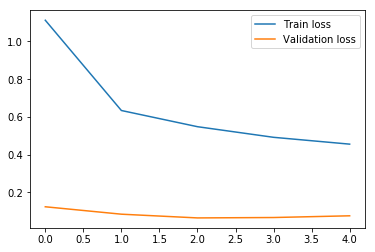

In [104]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])

In [106]:
print("\nLoss, Accuracy = ", model_2.evaluate(x_test, y_test))

10000/10000 [==============================] - 3s 329us/step

Loss, Accuracy =  [0.07558859052583575, 0.9843]


Как видите, точность довольно сильно подскочила. Попробуйте поиграться числом параметров и слоёв так, чтобы их стало меньше, а качество сетки стало лучше. Попробуйте обучать нейросетку большее количество эпох. 

Снова посмотрим на ошибки. 

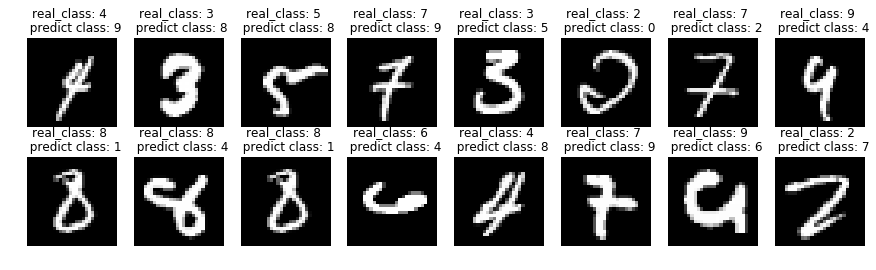

In [149]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_err[random_index, : ], cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(y_err[random_index], y_pred[random_index]))
plt.show()